In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm

In [4]:
SLOTS_PER_EPOCH = 32
MAX_COMMITTEES_PER_SLOT = 64
MAX_VALIDATORS_PER_COMMITTEE = 2048
MIN_PER_EPOCH_CHURN_LIMIT = 4
CHURN_LIMIT_QUOTIENT = 65536

In [5]:
def get_validator_churn_limit(n):
    '''
    n: number of active validators
    '''
    # NOTE: The churn limit is an integer, but
    # we use a FP number here to smooth the plot.
    return max(MIN_PER_EPOCH_CHURN_LIMIT, n / CHURN_LIMIT_QUOTIENT)

In [6]:
def eeks_to_exit(num_validators, fraction):
    '''
    Given a number of validators, returns how many eeks are needed
    for a `fraction` of them to exit the system at the current churn
    limit.

    NB: This function does not take into account the decreasing churn
        limit, thus giving shorter prediction (which in our case
        means also "safer"), nor does it take into account the
        MIN_VALIDATOR_WITHDRAWABILITY_DELAY (== 256 epochs, ~27 h).
    '''
    return num_validators / get_validator_churn_limit(num_validators) * fraction / 2048

In [20]:
def eeks_to_days(eeks):
    MINUTES_PER_EPOCH = 6.4
    return eeks * 2048 * MINUTES_PER_EPOCH / 60 / 24

In [7]:
def linspace_validators():
    a = 21_063 # validators at genesis
    b = MAX_VALIDATORS_PER_COMMITTEE * MAX_COMMITTEES_PER_SLOT * SLOTS_PER_EPOCH
    return np.linspace(a, b, num=2048)

In [8]:
# x: # validators
# y: % validator withdrawals
# z: how many eeks are needed to withdraw
xs, ys = np.meshgrid(
    linspace_validators(),      # number of validators
    np.linspace(0, 1, num=32),  # % validator withdrawals
)
print('Size:', xs.size)

zs = []
for x, y in zip(xs.ravel(), ys.ravel()):
    z = eeks_to_exit(x, y)
    zs.append(z)
zs = np.array(zs).reshape(xs.shape)

Size: 65536


In [9]:
# pd.Series(
#     (eeks_to_exit(x, 1/2) for x in xs[0]),
#     index=xs[0],
# ).plot(xlabel='# validators', ylabel='eeks to exit', figsize=(16, 4));

In [21]:
eeks_to_exit(2**18, 0.4426566296777251)

14.144

In [27]:
round(eeks_to_exit(2**18, 0.4426566296777251), 2)

14.17

In [24]:
eeks_to_days(eeks_to_exit(2**18, 0.442))

128.7418311111111

In [15]:
pd.Series(eeks_to_exit(430_000, x) for x in ys[:,0]).equals(
    pd.Series(eeks_to_exit(2**16*4, x) for x in ys[:,0])
)

True

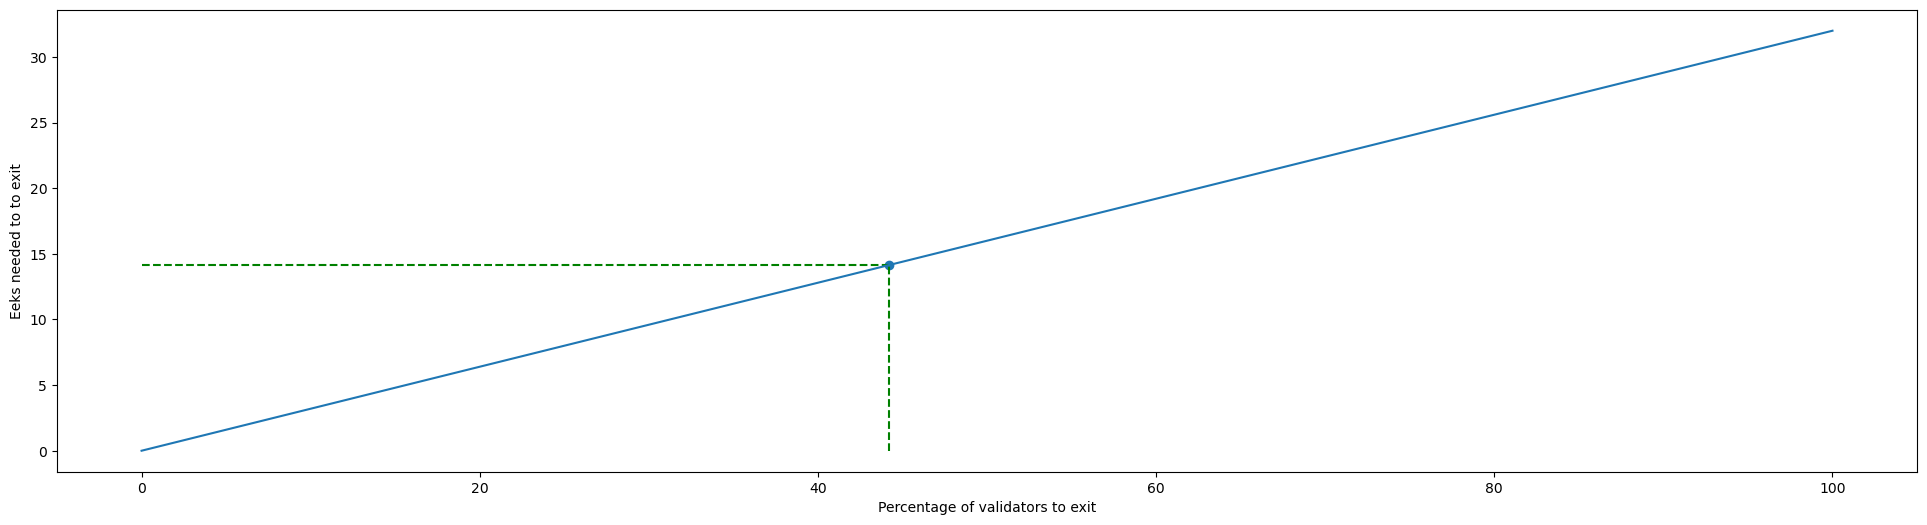

In [28]:
def twod():
    x = 44.2
    y = eeks_to_exit(430_000, x/100)
    plt.scatter(x, y)
    plt.plot([x, x], [0, y], c='green', linestyle='dashed')
    plt.plot([0, x], [y, y], c='green', linestyle='dashed')
    fig = pd.Series(
        (eeks_to_exit(430_000, x) for x in ys[:,0]),
        index=np.multiply(ys[:,0], 100),
    ).plot(
        xlabel='Percentage of validators to exit',
        ylabel='Eeks needed to to exit',
        figsize=(24, 6),
    )
    plt.savefig('2d.png')
twod()

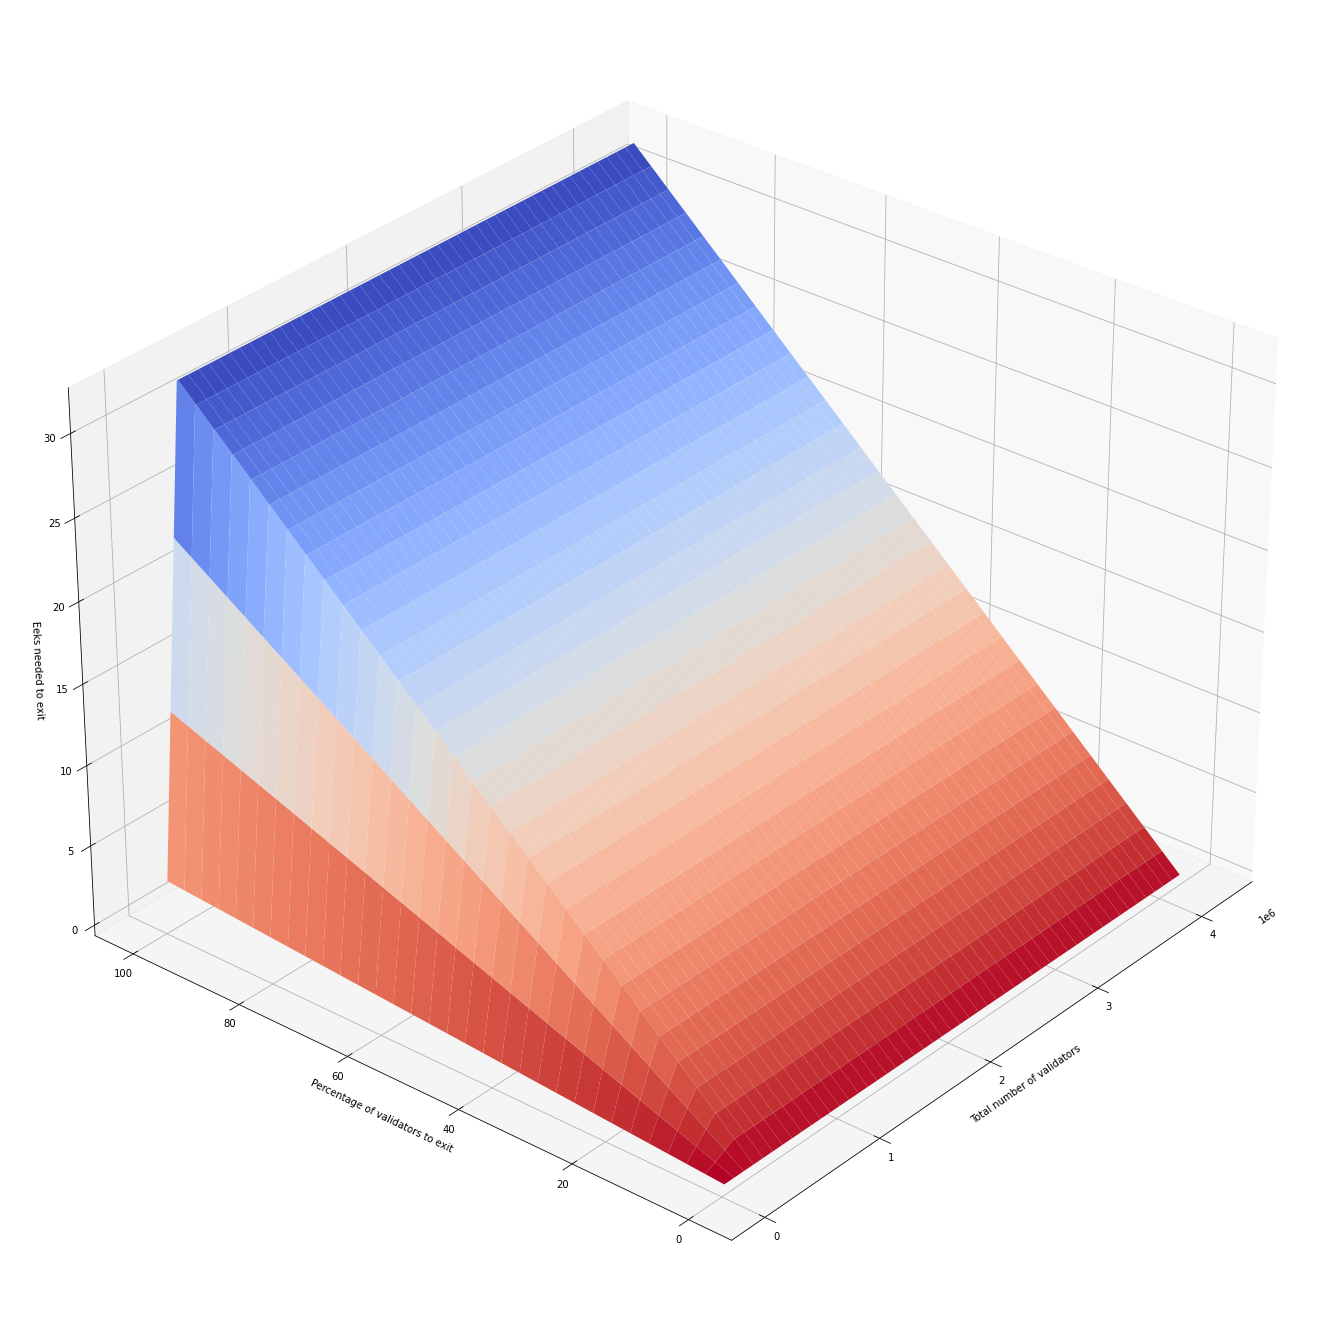

In [35]:
fig = plt.figure(figsize=(24, 24))
ax = plt.axes(projection='3d')
ax.plot_surface(xs, 100*ys, zs, cmap=cm.coolwarm_r)
ax.set_xlabel('Total number of validators')
ax.set_ylabel('Percentage of validators to exit')
ax.set_zlabel('Eeks needed to exit')
ax.view_init(30, 220)
plt.savefig('3d.png')
plt.show()